<a href="https://colab.research.google.com/github/Gabriel-Aspen/NFL-sentiment-analysis/blob/master/eagles_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
current_dir = os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pip install SpeechRecognition

     |████████████████████████████████| 32.8MB 123kB/s 


In [0]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 2.8MB/s 


##Sentiment Analysis from Transcibed Audio
1. Speech is transcribed in 10 second intervals using Google Web Speech API
2. The transcript is passed through vaderSentiment's SentimentIntensityAnalyzer. The metric I've chosen is compound because it's aggregation of positive, negative and neutral sentiment
3. The data is smoothed using a walking average

In [0]:
import speech_recognition as spr
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

functions
- makeTranscript() could be done better- try to get the length of the audio file in seconds- Done, now what can I do with that?
- smoothData() isn't returning all the values- why? Remember this is only used for visualization so it doesn't matter too much

In [0]:
#functions

#duration of audio recording
def getDuration(fname=None):
  import wave
  import contextlib
  if fname== None:
    print("no input")
  else:
    fname = 'nfl_SA/eagles.wav'
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        print(duration)

#transcriber
def makeTranscript(audio_file = False, steps=20, window_size=10, overlap= 0):
  if audio_file == False:
    return 'no input'
  else:
    transcript = []
    for step in range(steps):
      r = spr.Recognizer()
      with spr.AudioFile(audio_file) as source:
          offset_multi = window_size * (1-overlap) # overlap = the percent of the current window that will overlap with the next
          audio = r.record(source, duration=window_size , offset=step * offset_multi)
      try:
          text = r.recognize_google(audio) #choose recognizer
          transcript.append([text])
      except spr.UnknownValueError:
          text = 'error' #This might be messing something up
      except spr.RequestError as e:
          False
    return np.array(transcript)


#analyzer- Vader
def vaderAnalyzer(transcript, element= 'compound'):
  analyser_obj = SentimentIntensityAnalyzer()
  sent_dict = []
  for i in range(int(transcript.size)):
    elon = analyser_obj.polarity_scores(str(transcript[i]))
    sent_dict.append(elon)
  chosen_element = [] # either positive, negative, neutral or compound
  for i in range(len(sent_dict)):
    chosen_element.append(sent_dict[i][element])
  return chosen_element

#analyzer- TextBlob
def tbAnalyzer(transcript, element= 'polarity'):
  analyser_obj = SentimentIntensityAnalyzer()
  polarity = []
  subjectivity = []
  if element == 'polarity':
    for i in range(int(transcript.size)):
      elon = TextBlob(str(transcript[i]))
      polarity.append(elon.sentiment.polarity)
    return polarity
  if element == 'subjectivity':
    for i in range(int(transcript.size)):
      elon = TextBlob(str(transcript[i]))
      subjectivity.append(elon.sentiment.subjectivity)
    return subjectivity

#walking average- to smooth out data. N = number of neighbors to average with
def smoothData(scores, N = 3):
  cumsum, moving_aves = [0], []
  N = N
  for i, x in enumerate(scores, 1):
      cumsum.append(cumsum[i-1] + x)
      if i>=N:
          moving_ave = (cumsum[i] - cumsum[i-N])/N
          #can do stuff with moving_ave here
          moving_aves.append(moving_ave)
  return moving_aves

Run it: this will take a WHILE. Don't worry, I've saved it so you can just load it later

In [0]:
infile = 'nfl_SA/eagles.wav'

def makeTranscript(audio_file = False, steps=20, window_size=10, overlap= 0):
  if audio_file == False:
    return 'no input'
  else:
    transcript = []
    for step in range(steps):
      r = spr.Recognizer()
      with spr.AudioFile(audio_file) as source:
          offset_multi = window_size * (1-overlap) # overlap = the percent of the current window that will overlap with the next
          audio = r.record(source, duration=window_size , offset=step * offset_multi)
      try:
          text = r.recognize_google(audio) #choose recognizer
          transcript.append([text])
      except spr.UnknownValueError:
          text = 'error' #This might be messing something up
      except spr.RequestError as e:
          False
    return np.array(transcript)
transcript = makeTranscript(infile, steps= 900, window_size=12.5, overlap=.20)
scores = vaderAnalyzer(transcript, element= 'compound')

#sentiment scores
outfile_name = 'nfl_SA/eagles_900-12:5-20_vader-comp_IBM.pickle'
outpath = os.path.join(current_dir, outfile_name)
with open(outpath, 'wb') as pickle_out:
    pickle.dump(scores, pickle_out)
    pickle_out.close()

#transcript
outfile_name = 'nfl_SA/eagles_900-12:5-20_vader-comp_IBM_transcript.pickle'
outpath = os.path.join(current_dir, outfile_name)
with open(outpath, 'wb') as pickle_out:
    pickle.dump(transcript, pickle_out)
    pickle_out.close()

plt.plot(scores) # 10 second intervals = 9000 total seconds

The data is very noisy, try smoothing it out using a walking average (average with neighbors)

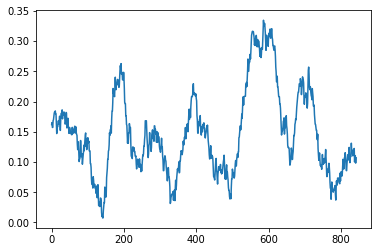

In [0]:
smoothed_data = smoothData(scores, N=50)
plt.plot(smoothed_data)

- notice how the sentiment scores are all above 0 now, and the number of samples are reduced to 850. We'll fix this later

Save the scores and transcript so we dont have to do it again

In [0]:
#sentiment scores
outfile_name = 'nfl_SA/eagles_900-10-0_vader-comp.pickle'
outpath = os.path.join(current_dir, outfile_name)
with open(outpath, 'wb') as pickle_out:
    pickle.dump(scores, pickle_out)
    pickle_out.close()

#transcript
outfile_name = 'nfl_SA/eagles_900-10-0_vader-comp_transcript.pickle'
outpath = os.path.join(current_dir, outfile_name)
with open(outpath, 'wb') as pickle_out:
    pickle.dump(transcript, pickle_out)
    pickle_out.close()


###Importing the data for yourself (from above)

In [0]:
import matplotlib.pyplot as plt
import pickle

#load the scores variable
infile_name = 'nfl_SA/eagles_900-10-0_vader-comp.pickle'
inpath = os.path.join(current_dir, infile_name)
with open(inpath, 'rb') as pickle_in:
    scores_old = pickle.load(pickle_in)
  
#load the transcript variable
infile_name = 'nfl_SA/eagles_900-10-0_vader-comp_transcript.pickle'
inpath = os.path.join(current_dir, infile_name)
with open(inpath, 'rb') as pickle_in:
    transcript_old = pickle.load(pickle_in)

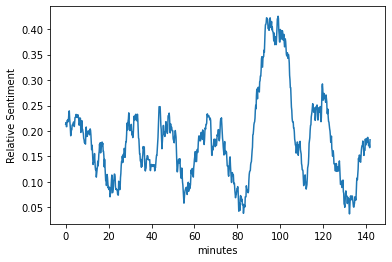

In [0]:
smoothed_data = smoothData(scores, N=50)

#unfortunately we lose some information while smoothing the data. I'm working on this.
#the following code converts the x axis to minutes and adjusts for the time compression
steps_total = 900
step_size = 10
minutes_total = (step_size*steps_total)/60
smoothing_compression_ratio = len(smoothed_data)/len(scores)

minutes = np.linspace(0, minutes_total, len(smoothed_data))
plt.plot(minutes*smoothing_compression_ratio, smoothed_data)
plt.xlabel('minutes')
plt.ylabel('Relative Sentiment'); #note: while smoothing the data makes it look cleaner, it doesn't reflect the actual sentiment
                                  #      score, however it will still show the general trend

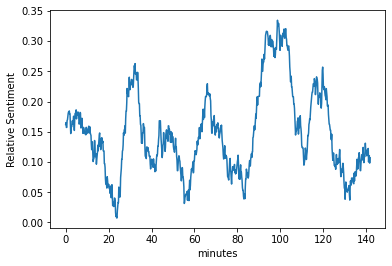

In [0]:
smoothed_data_old = smoothData(scores_old, N=50)

#unfortunately we lose some information while smoothing the data. I'm working on this.
#the following code converts the x axis to minutes and adjusts for the time compression
steps_total = 900
step_size = 10
minutes_total = (step_size*steps_total)/60
smoothing_compression_ratio = len(smoothed_data)/len(scores_old)

minutes = np.linspace(0, minutes_total, len(smoothed_data))
plt.plot(minutes*smoothing_compression_ratio, smoothed_data)
plt.xlabel('minutes')
plt.ylabel('Relative Sentiment'); #note: while smoothing the data makes it look cleaner, it doesn't reflect the actual sentiment
                                  #      score, however it will still show the general trend

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Sentement')

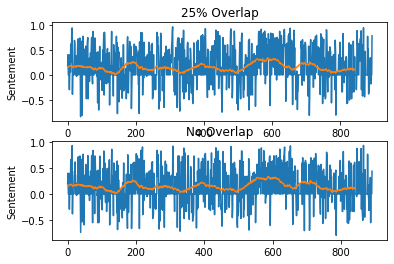

In [0]:
plt.subplot(2,1,1)
plt.plot(scores)
plt.subplot(2,1,1)
plt.plot(smoothed_data)
plt.title('25% Overlap')
plt.ylabel('Sentement')

plt.subplot(2,1,2)
plt.plot(scores_old)
plt.subplot(2,1,2)
plt.plot(smoothed_data_old)
plt.title('No Overlap')
plt.ylabel('Sentement')

----

In [0]:
import pandas as pd

scores_ = np.array(scores)
transcript_ = transcript[0:892,0]

concat = pd.DataFrame({'scores': scores_, 'transcript': transcript_})
pd.options.display.max_colwidth = 1000
concat

,scores,transcript
0,0.2023,two weeks of high pain is the great John Madden used to say it's time for a game to break out and not soon enough
1,0.4019,England chicken go up they won the toss they have the first so we'll see the Philadelphia offense you've got Barner and Clement
2,0.0000,back beat Tom Brady or on the sideline phones will go right to work after the kickoff
3,0.0000,man with the light bulb
4,0.0000,and it gets run out of bounds by Patrick Chung up at the 25-yard line what a story for Nick Foles but have you been reading about it here
...,...,...
887,-0.5574,pass interference call there is nobody anywhere close to his tall is Rob Gronkowski I was jamming with the line of scrimmage I would not let him know
888,0.1779,play the office ball Brady Under Pressure escapes the sack launching one for the end zone
889,0.0000,jump place and time Runs Out
890,0.0000,Philadelphia Eagles the long drought is over finally


### Side note: TextBlob will translate stuff!


In [0]:
futbol = TextBlob(str(transcript[0]))
print(futbol.translate(to='es'))

["dos semanas de mucho dolor es el gran John Madden solía decir que es hora de que se inicie un juego y no lo suficientemente pronto"]


In [0]:
sent = TextBlob("It doesn't matter if you move to another galaxy")
print(sent.translate(to='es'))

No importa si te mudas a otra galaxia


-----------


Waveplot

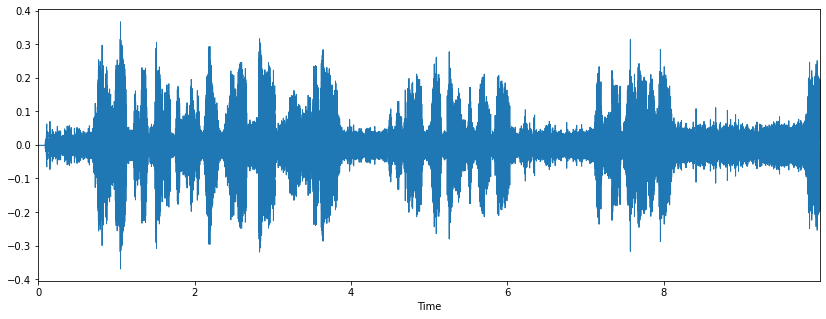

In [0]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_, sr=sr)

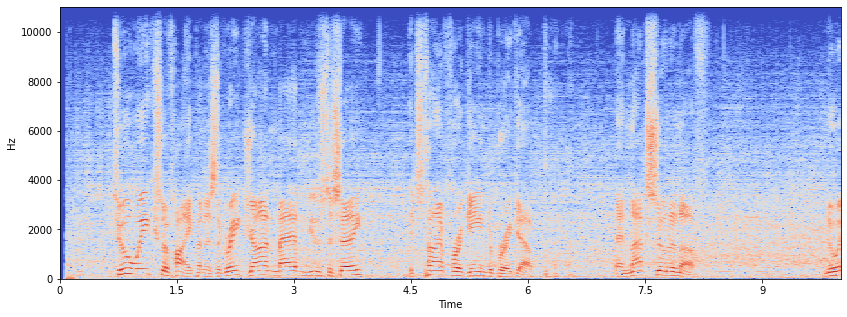

In [0]:
X = librosa.stft(x_)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

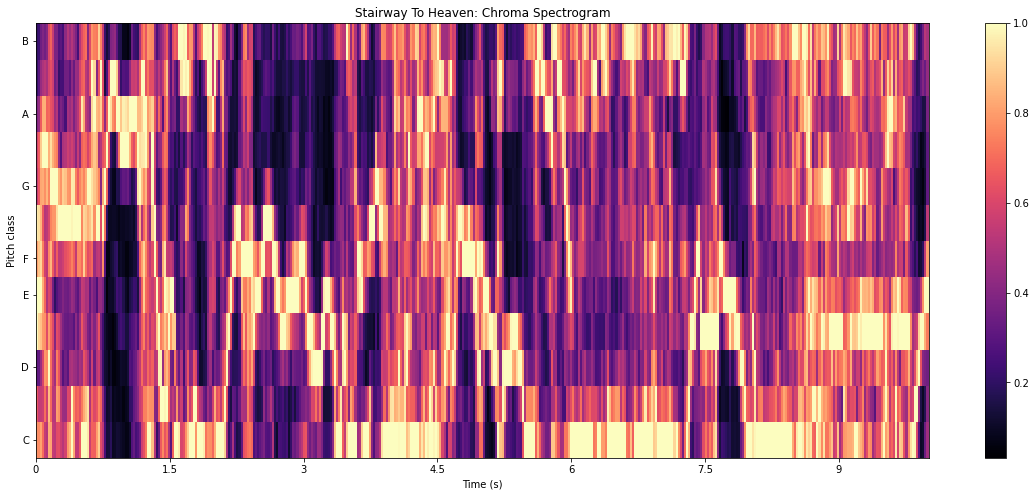

In [0]:
#kinda cool- shows the pitch
first_thirty_seconds = librosa.time_to_samples(30, sr=sr)
intro = x_[:first_thirty_seconds]
intro_harm = librosa.effects.harmonic(intro)
intro_chroma = librosa.feature.chroma_cqt(intro_harm, sr=sr)
plt.figure(figsize=(20,8))
plt.title('Stairway To Heaven: Chroma Spectrogram')
librosa.display.specshow(intro_chroma, sr=sr, x_axis='s', y_axis='chroma', )
plt.colorbar();